In [1]:
import pylab
from pycbc import waveform
from pycbc import conversions

import numpy

from scipy import interpolate

from pycbc.types import TimeSeries, FrequencySeries, Array, float32, float64, complex_same_precision_as, real_same_precision_as
from math import frexp
import numpy
import copy

def ceilpow2(n):
    """convenience function to determine a power-of-2 upper frequency limit"""
    signif,exponent = frexp(n)
    if (signif < 0):
        return 1;
    if (signif == 0.5):
        exponent -= 1;
    return (1) << exponent;

def coalign_waveforms(h1, h2, psd=None,
                      low_frequency_cutoff=None,
                      high_frequency_cutoff=None,
                      resize=True):

    from pycbc.filter import matched_filter
    mlen = ceilpow2(max(len(h1), len(h2)))

    h1 = h1.copy()
    h2 = h2.copy()

    if resize:
        h1.resize(mlen)
        h2.resize(mlen)
    elif len(h1) != len(h2) or len(h2) % 2 != 0:
        raise ValueError("Time series must be the same size and even if you do "
                         "not allow resizing")

    snr = matched_filter(h1, h2, psd=psd,
                         low_frequency_cutoff=low_frequency_cutoff,
                         high_frequency_cutoff=high_frequency_cutoff)

    _, l =  snr.abs_max_loc()
    rotation =  snr[l] / abs(snr[l])
    h1 = (h1.to_frequencyseries() * rotation).to_timeseries()
    h1.roll(l)

    h1 = TimeSeries(h1, delta_t=h2.delta_t, epoch=h2.start_time)
    return h1, h2
        
def ApproxWaveform (approx, m1, m2, sampleRate, fLow, trimZeros=False):
    hp, hc = waveform.get_td_waveform(approximant=approx,
                                mass1=m1,
                                mass2=m2,
                                delta_t=1.0/sampleRate,
                                f_lower=fLow)
    
    if (trimZeros == True):
        hp, hc = hp.trim_zeros(), hc.trim_zeros()
        
#     amp = waveform.utils.amplitude_from_polarizations(hp, hc)
#     f = waveform.utils.frequency_from_polarizations(hp, hc)
    
    return hp, hc
        
def SubtractWaveforms (approx1, approx2, m1, m2, sampleRate, fLow):
    hp1, hc1 = ApproxWaveform (approx1, m1, m2, sampleRate, fLow)
    hp2, hc2 = ApproxWaveform (approx2, m1, m2, sampleRate, fLow)
    
    hp1, hp2 = coalign_waveforms(hp1, hp2)
    hc1, hc2 = coalign_waveforms(hc1, hc2)
    
    f1 = waveform.utils.frequency_from_polarizations(hp1, hc1)
    f2 = waveform.utils.frequency_from_polarizations(hp2, hc2)

    pylab.plot(f1.sample_times, numpy.absolute(f1 - f2), label="|" + approx1 + " - " + approx2 + "|")

    pylab.yscale('log')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlabel('Time (s)')
    pylab.legend(loc='upper left')
    pylab.show()
    
f_low = 10
sample_rate = 2 * 4096

m1 = conversions.mass1_from_mtotal_q(100, 10)
m2 = conversions.mass2_from_mtotal_q(100, 10)

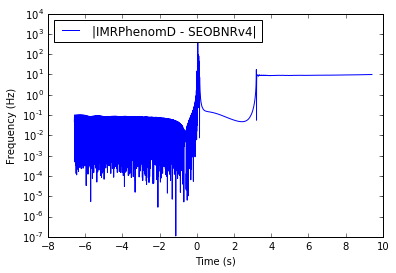

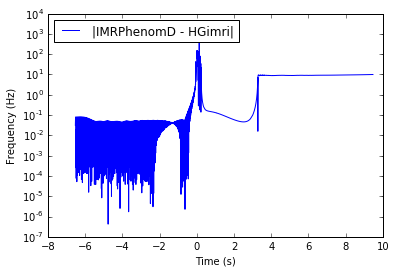

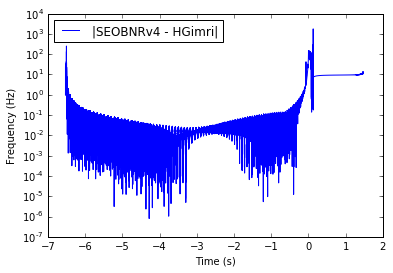

In [2]:
SubtractWaveforms ("IMRPhenomD", "SEOBNRv4", m1, m2, sample_rate, f_low)
SubtractWaveforms ("IMRPhenomD", "HGimri", m1, m2, sample_rate, f_low)
SubtractWaveforms ("SEOBNRv4", "HGimri", m1, m2, sample_rate, f_low)

In [ ]:
def OverlapTimes (sampleTimes1, sampleTimes2, sampleRate):
    start, end = OverlapPeriod (sampleTimes1, sampleTimes2)
    
    overlapSampleTimes = [t for t in frange(start, end, 1.0/sampleRate)]
    
    return overlapSampleTimes

def OverlapPeriod (sampleTimes1, sampleTimes2):
    start1, end1 = sampleTimes1[0], sampleTimes1[-1]
    start2, end2 = sampleTimes2[0], sampleTimes2[-1]
    
    start = max([start1, start2])
    end = min([end1, end2])
    
    return start, end

def frange(start, end, step):
    x = start

    while x < end:
        yield x
        x += step
        
def WaveformInterpolate (sampleTimes, sampleValues):
    interp = interpolate.splrep(sampleTimes, sampleValues, s=0)
    
    return interp